In [ ]:
# 1. Chargement des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# 2. Chargement du dataset
# Le dataset est stocké dans le projet sous backend/asstes/data/
# Utiliser un chemin relatif pour la portabilité
df = pd.read_csv('../asstes/data/supermarche_historique_ventes.csv')

# 3. Conversion de la colonne Date en datetime et tri chronologique
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Aperçu des données
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89100 entries, 89099 to 13140
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        89100 non-null  datetime64[ns]
 1   Product_ID                  89100 non-null  object        
 2   Product_Name                89100 non-null  object        
 3   Category                    89010 non-null  object        
 4   Unit_Price                  89100 non-null  float64       
 5   Daily_Sales                 89100 non-null  int64         
 6   Days_to_Expiration_on_Date  89100 non-null  int64         
 7   Total_Shelf_Life            89100 non-null  int64         
 8   Day_of_Week                 89100 non-null  int64         
 9   Month                       89100 non-null  int64         
 10  Week_of_Year                89100 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
m

In [2]:
# Vérifier les valeurs manquantes
print(df.isna().sum())

# Remplacer / supprimer si nécessaire
df['Daily_Sales'] = df['Daily_Sales'].fillna(0)

# S'assurer du bon type numérique pour les colonnes utiles
num_cols = ['Unit_Price','Daily_Sales','Days_to_Expiration_on_Date','Total_Shelf_Life']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Optionnel : supprimer lignes restantes avec NaN critiques
df = df.dropna(subset=['Daily_Sales'])

# Encodage du Product_ID (catégorie → nombre)
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df['Product_ID_enc'] = enc.fit_transform(df[['Product_ID']])


Date                           0
Product_ID                     0
Product_Name                   0
Category                      90
Unit_Price                     0
Daily_Sales                    0
Days_to_Expiration_on_Date     0
Total_Shelf_Life               0
Day_of_Week                    0
Month                          0
Week_of_Year                   0
dtype: int64


In [3]:
# On garde les variables temporelles déjà fournies
# Ajout de lags et moyennes mobiles pour capturer la dépendance temporelle

df = df.sort_values(['Product_ID_enc','Date'])

def add_lags(data, lags=[1,7,14]):
    for lag in lags:
        data[f'lag_{lag}'] = data.groupby('Product_ID_enc')['Daily_Sales'].shift(lag)
    data['rmean_7'] = data.groupby('Product_ID_enc')['Daily_Sales'].shift(1).rolling(7).mean()
    return data

df = add_lags(df)
df = df.dropna()          # retirer lignes sans historique suffisant
print(df.head())

            Date   Product_ID Product_Name Category  Unit_Price  Daily_Sales  \
25095 2024-05-02  00-119-8780      Halibut  Seafood        20.0            0   
25094 2024-05-03  00-119-8780      Halibut  Seafood        20.0            0   
25093 2024-05-04  00-119-8780      Halibut  Seafood        20.0            0   
25092 2024-05-05  00-119-8780      Halibut  Seafood        20.0            0   
25091 2024-05-06  00-119-8780      Halibut  Seafood        20.0            0   

       Days_to_Expiration_on_Date  Total_Shelf_Life  Day_of_Week  Month  \
25095                           0                 0            3      5   
25094                           0                 0            4      5   
25093                           0                 0            5      5   
25092                           0                 0            6      5   
25091                           0                 0            0      5   

       Week_of_Year  Product_ID_enc  lag_1  lag_7  lag_14  rmean_7  

In [4]:
# Car prévision temporelle → split chronologique
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df  = df.iloc[split_index:]

feature_cols = [
    'Product_ID_enc','Unit_Price','Day_of_Week','Month','Week_of_Year',
    'Days_to_Expiration_on_Date','Total_Shelf_Life','lag_1','lag_7','lag_14','rmean_7'
]

X_train, y_train = train_df[feature_cols], train_df['Daily_Sales']
X_test,  y_test  = test_df[feature_cols],  test_df['Daily_Sales']

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (60131, 11), Test: (15033, 11)


In [5]:
# Random Forest pour prévision
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Sauvegarde du modèle pour déploiement
with open("rf_demand_model.pkl","wb") as f:
    pickle.dump(rf_model,f)

MAE  : 0.09
RMSE : 0.20


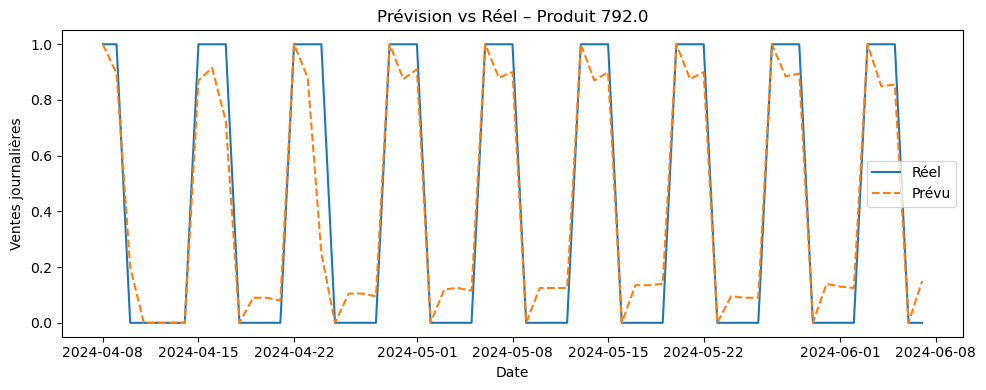

In [6]:
from sklearn.metrics import root_mean_squared_error
# Prédictions
y_pred = rf_model.predict(X_test)

# Métriques
mae  = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

# Graphique d’un produit exemple
sample_pid = test_df['Product_ID_enc'].iloc[0]
mask = test_df['Product_ID_enc']==sample_pid

plt.figure(figsize=(10,4))
plt.plot(test_df.loc[mask,'Date'], y_test[mask], label="Réel")
plt.plot(test_df.loc[mask,'Date'], y_pred[mask], label="Prévu", linestyle="--")
plt.title(f"Prévision vs Réel – Produit {sample_pid}")
plt.xlabel("Date")
plt.ylabel("Ventes journalières")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

def dynamic_pricing(unit_price: float, days_to_expiration: int) -> float:
    """
    Ajuste le prix d'un produit en fonction du nombre de jours avant sa péremption.
    """
    if days_to_expiration > 7:
        discount = 0.0           # pas de remise
    elif 3 <= days_to_expiration <= 7:
        discount = 0.10          # 10%
    elif 1 <= days_to_expiration < 3:
        discount = 0.25          # 25%
    else:  # 0 jour ou négatif
        discount = 0.50          # 50%

    new_price = unit_price * (1 - discount)
    return round(new_price, 2)


def apply_dynamic_pricing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applique la tarification dynamique à un DataFrame
    contenant les colonnes 'Unit_Price' et 'Days_to_Expiration_on_Date'.
    """
    if 'Unit_Price' not in df.columns or 'Days_to_Expiration_on_Date' not in df.columns:
        raise ValueError("Les colonnes 'Unit_Price' et 'Days_to_Expiration_on_Date' sont requises.")

    df = df.copy()
    df['Adjusted_Price'] = df.apply(
        lambda row: dynamic_pricing(
            unit_price=row['Unit_Price'],
            days_to_expiration=int(row['Days_to_Expiration_on_Date'])
        ),
        axis=1
    )
    return df


if __name__ == "__main__":
    # Exemple de données
    data = {
        'Product_ID': [1, 2, 3, 4],
        'Product_Name': ['Lait', 'Yaourt', 'Pâtes', 'Poulet'],
        'Unit_Price': [1000, 800, 1200, 2500],
        'Days_to_Expiration_on_Date': [10, 5, 2, 0]
    }

    df = pd.DataFrame(data)

    print("=== Données avant tarification dynamique ===")
    print(df)

    df_adjusted = apply_dynamic_pricing(df)

    print("\n=== Données après tarification dynamique ===")
    print(df_adjusted)


=== Données avant tarification dynamique ===
   Product_ID Product_Name  Unit_Price  Days_to_Expiration_on_Date
0           1         Lait        1000                          10
1           2       Yaourt         800                           5
2           3        Pâtes        1200                           2
3           4       Poulet        2500                           0

=== Données après tarification dynamique ===
   Product_ID Product_Name  Unit_Price  Days_to_Expiration_on_Date  \
0           1         Lait        1000                          10   
1           2       Yaourt         800                           5   
2           3        Pâtes        1200                           2   
3           4       Poulet        2500                           0   

   Adjusted_Price  
0          1000.0  
1           720.0  
2           900.0  
3          1250.0  
